# 在一分钟内实现一个图形分类应用

在本教程中，我们会演示使用TinyMS 0.3.1 API构建LeNet5模型，下载数据集，训练，启动服务器和推理的过程。

## 环境要求
 - Ubuntu: `18.04`
 - docker: `v18.06.1-ce`
 - Jupyter: 使用`TinyMS 0.3.1-Jupyter`，可参考 [快速安装TinyMS](https://tinyms.readthedocs.io/zh_CN/latest/quickstart/install.html) 部署该环境。
 
## 介绍

TinyMS是一个高级API，目的是让新手用户能够更加轻松地上手深度学习。TinyMS可以有效地减少用户在构建、训练、验证和推理一个模型过程中的操作次数。TinyMS也提供了教程和文档帮助开发者更好的上手和开发。

本教程包括6部分：`构建模型`、`下载数据集`、`训练`、`定义servable json`、`启动服务器`和`推理`，其中服务器将在一个子进程中启动。

In [1]:
import os
import json
from PIL import Image

from tinyms import context
from tinyms.data import MnistDataset, download_dataset
from tinyms.vision import mnist_transform, ImageViewer
from tinyms.model import Model, lenet5
import tinyms.optimizers as opt
from tinyms.serving import Server, Client
from tinyms.metrics import Accuracy
from tinyms.losses import SoftmaxCrossEntropyWithLogits
from tinyms.callbacks import ModelCheckpoint, CheckpointConfig, LossMonitor

[WARNING] ME(12716:140477914756928,MainProcess):2021-03-19-15:58:38.621.652 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. 构建模型

TinyMS封装了MindSpore LeNet5模型中的init和construct函数，代码行数能够大大减少，原有的大量代码段行数会被极限压缩:

In [2]:
# 构建网络
net = lenet5(class_num=10)
model = Model(net)

### 2. 下载数据集

如果`/home/jovyan`文件夹下没有创建`mnist`文件夹则MNIST数据集会被自动下载并存放到`/home/jovyan`文件夹，如果`mnist`文件夹已经存在于`/home/jovyan`文件夹，则此步操作会被跳过。

In [3]:
# 下载数据集
mnist_path = '/home/jovyan/mnist'
if not os.path.exists(mnist_path):
    download_dataset('mnist', '/home/jovyan')
    print('************Download complete*************')
else:
    print('************Dataset already exists.**************')

************Dataset already exists.**************


### 3. 训练模型

数据集中的训练集、验证集都会在此步骤中定义，同时也会定义训练参数。训练后生成的ckpt文件会保存到`/home/jovyan/tinyms/serving/lenet5`文件夹以便后续使用，训练完成后会进行验证并输出 `Accuracy`指标。

In [ ]:
# 创建mnist路径
ckpt_folder = '/home/jovyan/tinyms/serving/lenet5'
ckpt_path = '/home/jovyan/tinyms/serving/lenet5/lenet5.ckpt'
if not os.path.exists(ckpt_folder):
    !mkdir -p  /home/jovyan/tinyms/serving/lenet5
else:
    print('lenet5 ckpt folder already exists')

# 设置环境参数
device_target = "CPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)  
dataset_sink_mode = False

# 创建数据集
train_dataset = MnistDataset(os.path.join(mnist_path, "train"), shuffle=True)
train_dataset = mnist_transform.apply_ds(train_dataset)
eval_dataset = MnistDataset(os.path.join(mnist_path, "test"), shuffle=True)
eval_dataset = mnist_transform.apply_ds(eval_dataset)

# 设置训练参数
lr = 0.01
momentum = 0.9
epoch_size = 1
batch_size = 32

# 定义loss函数
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义optimizer
net_opt = opt.Momentum(net.trainable_params(), lr, momentum)
net_metrics={"Accuracy": Accuracy()}
model.compile(loss_fn=net_loss, optimizer=net_opt, metrics=net_metrics)

print('************************Start training*************************')
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10))
model.train(epoch_size, train_dataset, callbacks=[ckpoint_cb, LossMonitor()],dataset_sink_mode=dataset_sink_mode)
print('************************Finished training*************************')
model.save_checkpoint(ckpt_path)


model.load_checkpoint(ckpt_path)
print('************************Start evaluation*************************')
acc = model.eval(eval_dataset, dataset_sink_mode=dataset_sink_mode)
print("============== Accuracy:{} ==============".format(acc))

### 4. 定义servable.json

定义lenet5 servable json文件：servable json文件定义了servable名称，模型名称，模型格式和分类数量，以便后续推理使用。

In [5]:
servable_json = [{'name': 'lenet5', 
                  'description': 'This servable hosts a lenet5 model predicting numbers', 
                  'model': {
                      "name": "lenet5", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/home/jovyan/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 5. 启动服务器

#### 5.1 介绍
TinyMS推理是C/S（Client/Server）架构。TinyMS使用[Flask](https://flask.palletsprojects.com/en/1.1.x/)这个轻量化的网页服务器架构作为C/S通讯的基础架构。为了能够对模型进行推理，用户必须首先启动服务器。如果成功启动，服务器会在子进程中运行并且会监听从地址127.0.0.1，端口号5000发送来的POST请求并且使用MindSpore作为后端来处理这些请求。后端会构建模型，运行推理并且返回结果给客户端。

#### 5.2 启动服务器

运行下列代码以启动服务器：

In [ ]:
server = Server(serving_path="/home/jovyan/tinyms/serving/")
server.start_server()

 * Serving Flask app 'tinyms.serving.server.server' (lazy loading)

 * Environment: production


   Use a production WSGI server instead.

 * Debug mode: off



出现如上提示说明服务器已启动且正在运行。

服务器启动后，我们要到菜单栏点击`File`=>`new Notebook`创建一个新的jupyter的文件，然后继续完成客户端的操作。

In [ ]:
import os
from PIL import Image

from tinyms.vision import ImageViewer
from tinyms.serving import Server, Client

### 6. 推理

#### 6.1 上传图片

用户需要上传一张0~9之间的数字图片作为输入。如果使用命令行终端，可以使用`scp`或者`wget`命令获取图片，如果使用Jupyter，点击菜单右上方的`Upload`按钮并且选择上传的图片。本教程中使用的图片可以点击[这里](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png)进行下载，将图片保存在`/home/jovyan`文件夹下，重命名为'7.png'（或者任何用户喜欢的名字）。

或者运行如下的代码下载图片：

In [7]:
if not os.path.exists('/home/jovyan/7.png'):
    !wget -P /home/jovyan https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
else:
    print('7.png already exists')

--2022-01-26 18:42:14--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.113, 49.4.112.90, 121.36.121.44
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34970 (34K) [image/png]
Saving to: ‘/home/jovyan/7.png’

7.png               100%[===================>]  34.15K  --.-KB/s    in 0.07s   

2022-01-26 18:42:14 (470 KB/s) - ‘/home/jovyan/7.png’ saved [34970/34970]



#### 6.2 List servables

使用`list_servables`函数检查当前后端的serving模型。

In [8]:
client=Client()
client.list_servables()

[{'description': 'This servable hosts a lenet5 model predicting numbers',
  'model': {'class_num': 10, 'format': 'ckpt', 'name': 'lenet5'},
  'name': 'lenet5'}]

如果输出的`description`字段显示这是一个`lenet5`的模型，则可以继续到下一步发送推理请求。

#### 6.3 发送推理请求

运行`predict`函数发送推理请求，第4个参数选择`TOP1_CLASS`或者`TOP5_CLASS`输出:

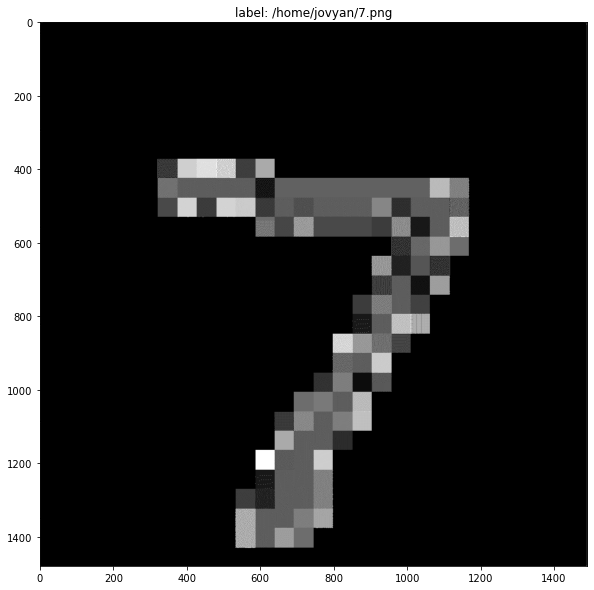

TOP1: 7, score: 0.9997


In [9]:
# 设置图片路径和输出策略（可以在TOP1和TOP5中选择）
image_path = "/home/jovyan/7.png"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset='mnist', strategy='TOP1_CLASS')
# predict方法的四个参数分别是图片路径、servable名称，数据集名称（默认MNIST）和输出策略（默认输出TOP1，可以选择TOP5）
img_viewer = ImageViewer(Image.open(image_path), image_path)
img_viewer.show()
print(client.predict(image_path,'lenet5', 'mnist', strategy))

如果用户能看到类似如下输出:  
```
TOP1: 7, score: 0.99934917688369750977
```  
那么意味着已经进行了一次成功的推理。

## 关闭服务器

运行以下代码关闭服务器：

In [10]:
server.shutdown()

'Server shutting down...'